### Importing relevant libraries

In [57]:
import nltk
from nltk import tokenize
from nltk.corpus import PlaintextCorpusReader, stopwords
from nltk.util import ngrams
from nltk.tokenize import sent_tokenize, word_tokenize
import string
import statistics
from sklearn.feature_extraction.text import CountVectorizer
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import random
from collections import  Counter, defaultdict

### Loading CSV file

In [34]:
contracts_df = pd.read_excel('../data/contract_new.xlsx')

In [35]:
contracts_df['content'] = contracts_df['content'].apply(lambda x: x.lower())

In [36]:
contracts_df.head()

,contract,content
0,2ThemartComInc_19990826_10-12G_EX-10.10_670028...,co-branding and advertising agreement this co-...
1,ABILITYINC_06_15_2020-EX-4.25-SERVICESAGREEMEN...,exhibit 4.25 information in this exhibit ident...
2,ACCELERATEDTECHNOLOGIESHOLDINGCORP_04_24_2003-...,exhibit 10.13 joint venture agreement collecti...
3,ACCURAYINC_09_01_2010-EX-10.31-DISTRIBUTORAGRE...,exhibit 10.31 pursuant to 17 c.f.r. § 240.24b-...
4,ADAMSGOLFINC_03_21_2005-EX-10.17-ENDORSEMENTAG...,redacted copy confidential treatment requested...


In [38]:
contracts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510 entries, 0 to 509
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   contract        510 non-null    object
 1   content         510 non-null    object
 2   sentence_count  510 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 12.1+ KB


### Data Exploration

* Number of sentences
* Number of words
* Number of characters
* Number of stopwords
* Number of numerics
* Average word length
* Common stopwords
* Common words
* N-grams Analysis

#### Number of sentences

In [39]:
contracts_df['sentence_count'] = contracts_df['content'].apply(lambda x: len(tokenize.sent_tokenize(x)))

In [40]:
contracts_df[['content', 'sentence_count']].head()

,content,sentence_count
0,co-branding and advertising agreement this co-...,177
1,exhibit 4.25 information in this exhibit ident...,121
2,exhibit 10.13 joint venture agreement collecti...,50
3,exhibit 10.31 pursuant to 17 c.f.r. § 240.24b-...,183
4,redacted copy confidential treatment requested...,103


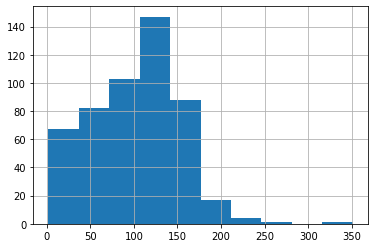

In [41]:
contracts_df['sentence_count'].hist()

#### Number of words

In [42]:
contracts_df['word_count'] = contracts_df['content'].apply(lambda x: len(str(x).split(" ")))

In [43]:
contracts_df[['content', 'word_count']].head()

,content,word_count
0,co-branding and advertising agreement this co-...,4467
1,exhibit 4.25 information in this exhibit ident...,4115
2,exhibit 10.13 joint venture agreement collecti...,1911
3,exhibit 10.31 pursuant to 17 c.f.r. § 240.24b-...,4993
4,redacted copy confidential treatment requested...,3770


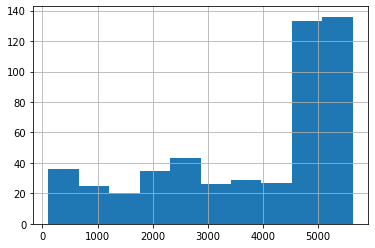

In [44]:
contracts_df['word_count'].hist()

#### Number of characters

In [45]:
contracts_df['char_count'] = contracts_df['content'].str.len()

In [46]:
contracts_df[['content','char_count']].head()

,content,char_count
0,co-branding and advertising agreement this co-...,28764
1,exhibit 4.25 information in this exhibit ident...,26287
2,exhibit 10.13 joint venture agreement collecti...,11917
3,exhibit 10.31 pursuant to 17 c.f.r. § 240.24b-...,32767
4,redacted copy confidential treatment requested...,24203


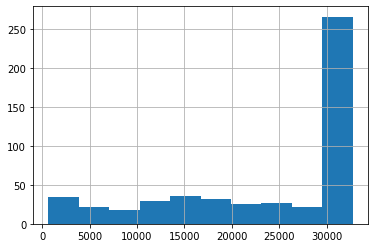

In [47]:
contracts_df['char_count'].hist()

#### Number of stopwords

In [49]:
# number of stopwords
stop = stopwords.words('english')
contracts_df['stopwords'] = contracts_df['content'].apply(lambda x: len([x for x in x.split() if x in stop]))

In [50]:
contracts_df[['content','stopwords']].head()

,content,stopwords
0,co-branding and advertising agreement this co-...,1753
1,exhibit 4.25 information in this exhibit ident...,1767
2,exhibit 10.13 joint venture agreement collecti...,840
3,exhibit 10.31 pursuant to 17 c.f.r. § 240.24b-...,2058
4,redacted copy confidential treatment requested...,1407


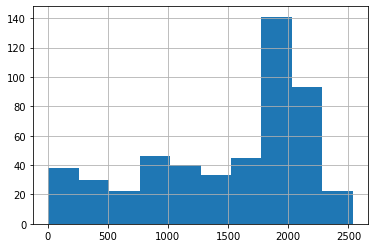

In [51]:
contracts_df['stopwords'].hist()

#### Number of numerics

In [52]:
contracts_df['numerics'] = contracts_df['content'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))

In [53]:
contracts_df[['content','numerics']].head()

,content,numerics
0,co-branding and advertising agreement this co-...,16
1,exhibit 4.25 information in this exhibit ident...,19
2,exhibit 10.13 joint venture agreement collecti...,8
3,exhibit 10.31 pursuant to 17 c.f.r. § 240.24b-...,17
4,redacted copy confidential treatment requested...,28


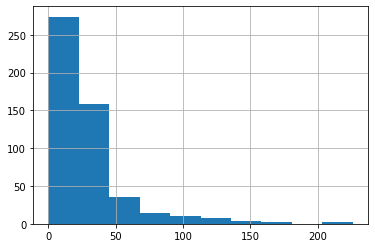

In [54]:
contracts_df['numerics'].hist()

### Analysis of overall feature attributes

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000256AB092748>,
      dtype=object)

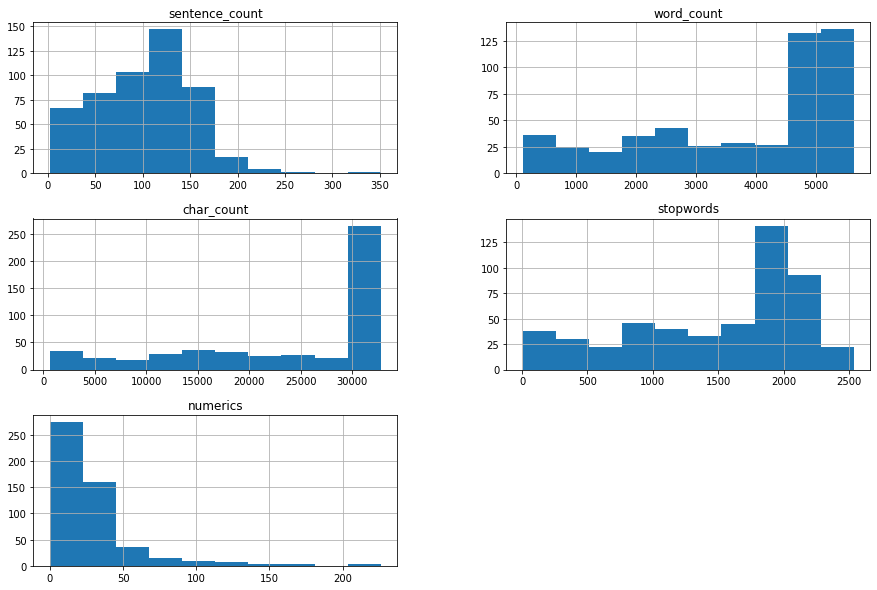

In [55]:
contracts_df[['sentence_count', 'word_count', 'char_count', 'stopwords', 'numerics']].hist(figsize=(15,10))

In [56]:
contracts_df[['sentence_count', 'word_count', 'char_count', 'stopwords', 'numerics']].describe()

,sentence_count,word_count,char_count,stopwords,numerics
count,510.000000,510.000000,510.000000,510.000000,510.000000
mean,101.094118,3761.537255,24145.556863,1493.937255,29.833333
std,50.924565,1645.555132,10559.227447,675.722200,31.550279
min,2.000000,109.000000,645.000000,7.000000,0.000000
25%,62.250000,2457.000000,16047.500000,963.250000,12.000000
50%,107.000000,4790.500000,31997.000000,1786.500000,21.000000
75%,136.000000,5083.750000,32767.000000,2010.500000,35.000000
max,351.000000,5631.000000,32767.000000,2536.000000,226.000000


#### Average sentence length

In [58]:
def remove_punctuation_and_tokenize(sentence):
    return word_tokenize(sentence.translate(str.maketrans({a: None for a in string.punctuation})))

In [61]:
def get_avg_sent_length(text):
    sentence_list = sent_tokenize(text.strip())
    word_list = [remove_punctuation_and_tokenize(words) for words in sentence_list]
    length_list = [len(word) for word in word_list]
    return float(format(statistics.mean(length_list), '.2f'))

In [62]:
contracts_df['avg_sent_length'] = contracts_df['content'].apply(lambda x: get_avg_sent_length(x))

In [64]:
contracts_df[['content','avg_sent_length']].head()

,content,avg_sent_length
0,co-branding and advertising agreement this co-...,25.23
1,exhibit 4.25 information in this exhibit ident...,33.70
2,exhibit 10.13 joint venture agreement collecti...,38.06
3,exhibit 10.31 pursuant to 17 c.f.r. § 240.24b-...,27.28
4,redacted copy confidential treatment requested...,35.80


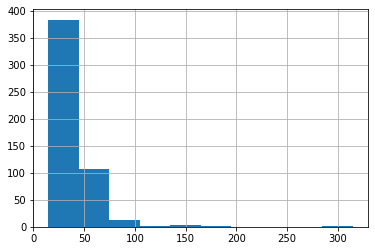

In [65]:
contracts_df['avg_sent_length'].hist()

In [67]:
contracts_df['avg_sent_length'].mode()

0    27.77
1    30.56
dtype: float64

#### Average word length

In [22]:
contracts_df['avg_word_length'] = contracts_df['content'].apply(lambda x: sum([len(word) for word in str(x).split(" ")])/len(str(x).split(" ")))

In [23]:
contracts_df[['content','avg_word_length']].head()

,content,avg_word_length
0,co-branding and advertising agreement this co-...,5.439445
1,exhibit 4.25 information in this exhibit ident...,5.388335
2,exhibit 10.13 joint venture agreement collecti...,5.236525
3,exhibit 10.31 pursuant to 17 c.f.r. § 240.24b-...,5.562788
4,redacted copy confidential treatment requested...,5.420159


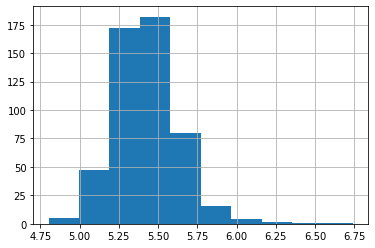

In [24]:
contracts_df['avg_word_length'].hist()

#### Common Stopwords

In [25]:
#create corpus
corpus=[]
new= contracts_df['content'].str.split()
new=new.values.tolist()
corpus=[word for i in new for word in i]

<BarContainer object of 10 artists>

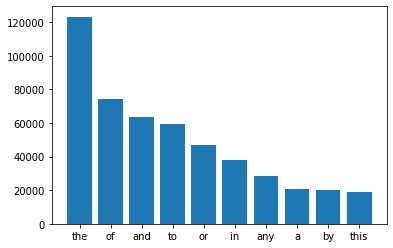

In [26]:
#top stopwords used in all documents
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y)

#### Common Words

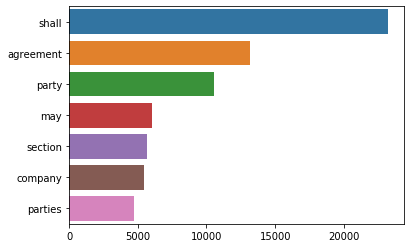

In [27]:
counter=Counter(corpus)
most=counter.most_common()

x, y= [], []
for word,count in most[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

In [ ]:
#clean out punctuation and special characters
# contracts_df['text_cleaned'] = contracts_df['content'].apply(lambda x: re.sub('[^A-Za-z0-9.,\-\()/: ]+', ' ', x))

In [ ]:
#create new corpus without special characters or punctuation
# corpus_cleaned=[]
# new= contracts_df['text_cleaned'].str.split()
# new=new.values.tolist()
# corpus_cleaned=[word for i in new for word in i]

In [ ]:
# most common words
# counter=Counter(corpus_cleaned)
# most=counter.most_common()

# x, y= [], []
# for word,count in most[:40]:
#     if (word not in stop):
#         x.append(word)
#         y.append(count)
        
# sns.barplot(x=y,y=x)

#### N-grams Analysis

In [28]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

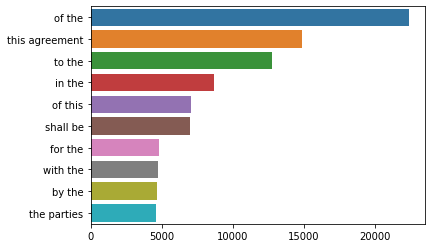

In [29]:
#bigram
top_n_bigrams=get_top_ngram(contracts_df['content'],2)[:10] 
x,y=map(list,zip(*top_n_bigrams)) 
sns.barplot(x=y,y=x)

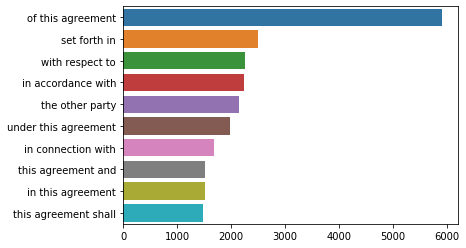

In [30]:
#trigram
top_tri_grams=get_top_ngram(contracts_df['content'],n=3)
x,y=map(list,zip(*top_tri_grams))
sns.barplot(x=y,y=x)

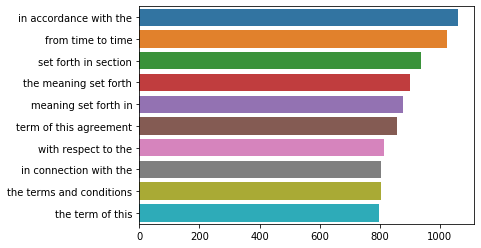

In [32]:
#4-gram
top_tri_grams=get_top_ngram(contracts_df['content'],n=4)
x,y=map(list,zip(*top_tri_grams))
sns.barplot(x=y,y=x)